In [1]:
# ============================================================
# BASE NLP PIPELINE — FULL COMMENTED VERSION
# Master in Big Data / Information Retrieval
# ============================================================

# -----------------------------
# 1. INSTALL REQUIRED PACKAGES
# -----------------------------
# (In Colab, you may need to install unidecode and wordcloud)

!pip install unidecode wordcloud nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.5 MB/s eta 0:00:00


In [2]:
# -----------------------------
# 2. IMPORT LIBRARIES
# -----------------------------

# Regular expressions for tokenization
import re

# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import ItalianStemmer

# Accent normalization
from unidecode import unidecode

# Frequency counter (TF statistics)
from collections import Counter

# Wordcloud visualization
from wordcloud import WordCloud

# Plotting utilities
import matplotlib.pyplot as plt

# Numerical utilities (for Zipf analysis)
import numpy as np

# Allow matplotlib to display inline
%matplotlib inline

# Download stopwords (only required once per runtime)
nltk.download("stopwords")

# Load Italian stopword list into a set
# Using a set ensures fast membership checks
STOPWORDS = set(stopwords.words("italian"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# ------------------------------------------------------------
# 3. LOAD AND TOKENIZE THE TEXT FILE
# ------------------------------------------------------------

def get_file_tokens(filename):
    """
    Reads a UTF-8 encoded file and tokenizes it using
    a regex that splits on non-alphanumeric characters.
    """
    tokens = []

    # Always specify encoding when dealing with text!
    with open(filename, encoding="utf-8") as f:
        for line in f:
            # Split on sequences of non-word characters
            tokens += re.split(r"\W+", line, flags=re.UNICODE)

    return tokens

In [4]:
# Download corpus (example corpus used in class)
!wget https://raw.githubusercontent.com/giusprencunipi/IR-Master/main/data/divinaCommedia.txt

--2026-02-28 12:08:25--  https://raw.githubusercontent.com/giusprencunipi/IR-Master/main/data/divinaCommedia.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 543209 (530K) [text/plain]
Saving to: ‘divinaCommedia.txt’

divinaCommedia.txt  100%[===================>] 530.48K  --.-KB/s    in 0.1s    

2026-02-28 12:08:26 (3.87 MB/s) - ‘divinaCommedia.txt’ saved [543209/543209]



In [7]:
# Load tokens
tokens = get_file_tokens("divinaCommedia.txt")

print("First 30 tokens:")
print(tokens[:30])

First 30 tokens:
['LA', 'DIVINA', 'COMMEDIA', '', 'di', 'Dante', 'Alighieri', '', 'INFERNO', '', '', '', '', '', '', '', 'Inferno', 'Canto', 'I', '', '', '', '', 'Nel', 'mezzo', 'del', 'cammin', 'di', 'nostra', 'vita']


In [8]:
# ------------------------------------------------------------
# 4. BASIC TF STATISTICS
# ------------------------------------------------------------

def basic_stats(tokens):
    """
    Compute and print:
    - total tokens
    - vocabulary size
    - number of hapax legomena
    - top 10 frequent words
    """

    c = Counter(tokens)

    total_tokens = sum(c.values())
    vocab_size = len(c)

    # Words that appear only once
    hapaxes = len([w for w in c if c[w] == 1])

    print("Total tokens:", total_tokens)
    print("Vocabulary size:", vocab_size)
    print("Hapax legomena:", hapaxes)
    print("Top 10 words:", c.most_common(10))

    return c


def generate_wordcloud(freq):
    """
    Generate and display a wordcloud from a frequency dictionary.
    """

    wc = WordCloud(background_color="white") \
         .generate_from_frequencies(freq)

    plt.figure(figsize=(8,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


===== BASELINE =====
Total tokens: 121998
Vocabulary size: 13518
Hapax legomena: 7777
Top 10 words: [('', 20083), ('e', 3687), ('che', 3673), ('l', 2616), ('la', 2260), ('a', 2008), ('di', 1843), ('non', 1350), ('per', 1325), ('in', 1081)]


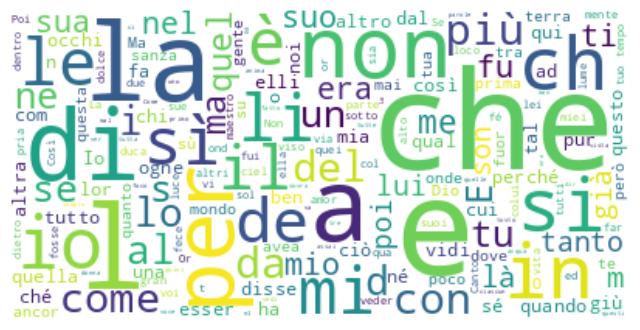

In [9]:
# -----------------------------
# BASELINE ANALYSIS
# -----------------------------

print("\n===== BASELINE =====")
c_baseline = basic_stats(tokens)
generate_wordcloud(c_baseline)


===== AFTER LENGTH FILTER =====
Total tokens: 68600
Vocabulary size: 13359
Hapax legomena: 7756
Top 10 words: [('che', 3673), ('non', 1350), ('per', 1325), ('più', 646), ('con', 624), ('come', 578), ('del', 564), ('quel', 353), ('mio', 311), ('nel', 296)]


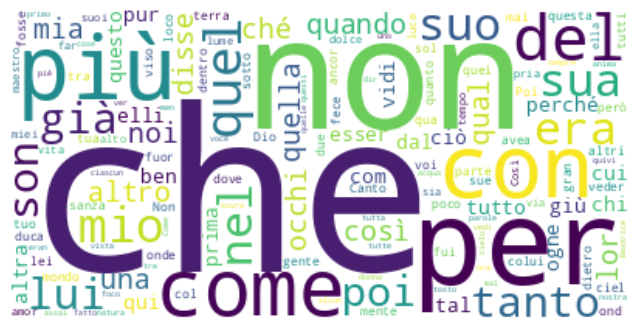

In [10]:
# ------------------------------------------------------------
# 5. REMOVE EMPTY AND SHORT TOKENS
# ------------------------------------------------------------

# Remove:
# - empty strings
# - tokens shorter than 3 characters

tokens_clean = [t for t in tokens if t and len(t) >= 3]

print("\n===== AFTER LENGTH FILTER =====")
c_len = basic_stats(tokens_clean)
generate_wordcloud(c_len)


===== AFTER STOPWORD REMOVAL =====
Total tokens: 52103
Vocabulary size: 13145
Hapax legomena: 7712
Top 10 words: [('quel', 353), ('tanto', 238), ('son', 237), ('già', 236), ('poi', 234), ('quando', 232), ('così', 231), ('altro', 224), ('occhi', 212), ('disse', 207)]


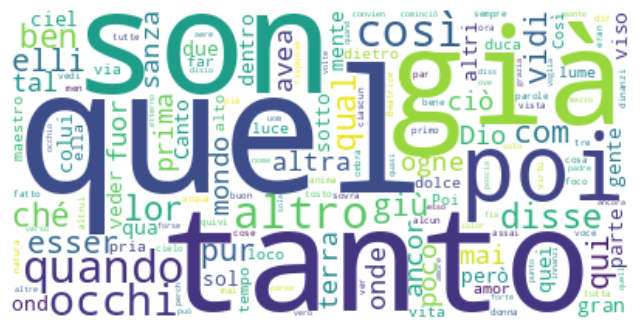

In [11]:
# ------------------------------------------------------------
# 6. REMOVE STOPWORDS
# ------------------------------------------------------------

# Important: lowercase before checking stopwords
tokens_stop = [t for t in tokens_clean
               if t.lower() not in STOPWORDS]

print("\n===== AFTER STOPWORD REMOVAL =====")
c_stop = basic_stats(tokens_stop)
generate_wordcloud(c_stop)


===== AFTER NORMALIZATION =====
Total tokens: 52103
Vocabulary size: 12403
Hapax legomena: 7151
Top 10 words: [('quel', 378), ('poi', 319), ('cosi', 310), ('quando', 277), ('gia', 268), ('tanto', 249), ('son', 238), ('altro', 225), ('qual', 213), ('occhi', 212)]


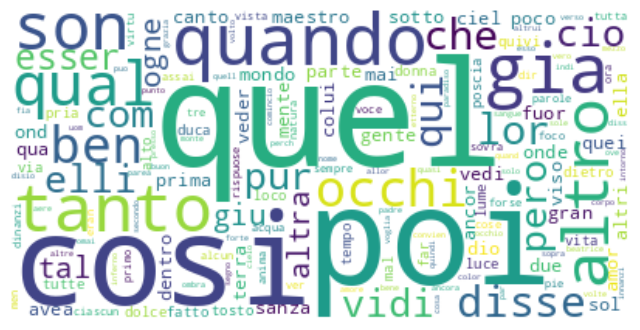

In [12]:
# ------------------------------------------------------------
# 7. NORMALIZATION (LOWERCASE + ACCENT REMOVAL)
# ------------------------------------------------------------

def normalize_words(words):
    """
    Normalize tokens by:
    - converting to lowercase
    - removing accents
    """
    return [unidecode(w.lower()) for w in words]


tokens_norm = normalize_words(tokens_stop)

print("\n===== AFTER NORMALIZATION =====")
c_norm = basic_stats(tokens_norm)
generate_wordcloud(c_norm)


===== AFTER STEMMING =====
Total tokens: 52103
Vocabulary size: 7363
Hapax legomena: 3620
Top 10 words: [('cos', 433), ('quel', 378), ('quand', 331), ('tant', 325), ('poi', 319), ('diss', 298), ('ben', 275), ('gia', 268), ('occhi', 262), ('sol', 259)]


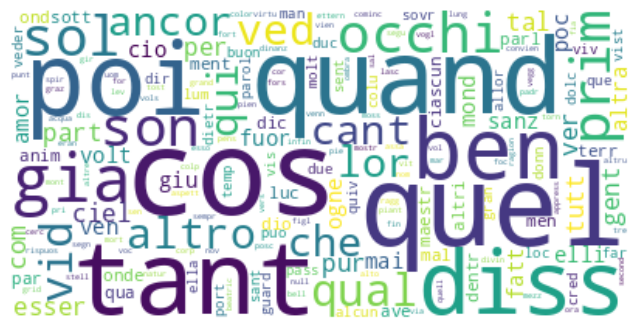

In [13]:
# ------------------------------------------------------------
# 8. STEMMING
# ------------------------------------------------------------

# Initialize stemmer once
stemmer = ItalianStemmer()

def stem_words(words):
    """
    Apply Italian stemming.
    This reduces morphological variants.
    """
    return [stemmer.stem(w) for w in words]


tokens_stem = stem_words(tokens_norm)

print("\n===== AFTER STEMMING =====")
c_stem = basic_stats(tokens_stem)

# Wordcloud from stems (less readable)
generate_wordcloud(c_stem)


===== AFTER DESTEMMING =====
Total tokens: 52103
Vocabulary size: 7363
Hapax legomena: 3620
Top 10 words: [('cosi', 433), ('quel', 378), ('quando', 331), ('tanto', 325), ('poi', 319), ('disse', 298), ('ben', 275), ('gia', 268), ('occhi', 262), ('sol', 259)]


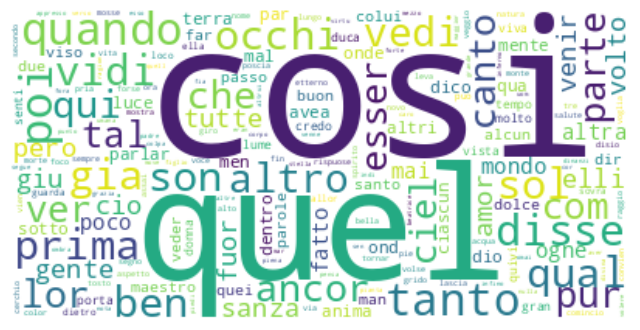

In [14]:
# ------------------------------------------------------------
# 9. DE-STEMMING (RESTORE READABILITY)
# ------------------------------------------------------------

def get_stem_mapping(words):
    """
    Build mapping:
    stem -> Counter(original surface forms)
    """
    mapping = {}

    for w in words:
        stem = stemmer.stem(w)

        if stem not in mapping:
            mapping[stem] = Counter()

        mapping[stem].update([w])

    return mapping


def destem_words(stems, mapping):
    """
    Replace each stem with the most frequent
    original word associated with that stem.
    """
    return [mapping[s].most_common(1)[0][0] for s in stems]


# Build mapping from normalized words
mapping = get_stem_mapping(tokens_norm)

# Replace stems with readable representative words
tokens_destem = destem_words(tokens_stem, mapping)

print("\n===== AFTER DESTEMMING =====")
c_destem = basic_stats(tokens_destem)
generate_wordcloud(c_destem)

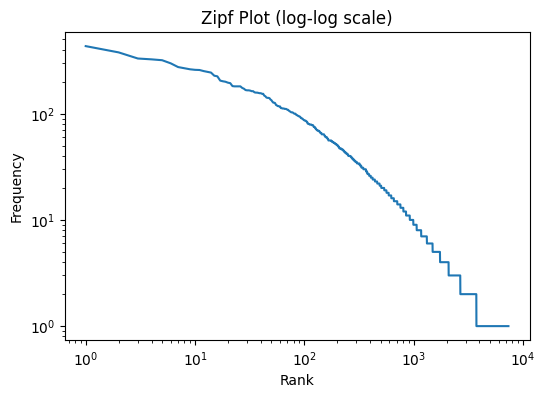

In [15]:
# ------------------------------------------------------------
# 10. ZIPF ANALYSIS (LOG-LOG PLOT)
# ------------------------------------------------------------

# Sort frequencies descending
freqs = np.array(sorted(c_destem.values(), reverse=True))

# Create rank array
ranks = np.arange(1, len(freqs) + 1)

plt.figure(figsize=(6,4))
plt.loglog(ranks, freqs)

plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Zipf Plot (log-log scale)")
plt.show()